# Question 2: Node Classification in a Heterogeneous Graph

In this question, you will explore node classifcation using GNNs in a heterogeneous graph with two types of nodes containing different number of features.

## Setting a Seed for Reproducibility

To ensure that our results are reproducible, we will set a fixed seed for the random number generator. This step is crucial for educational and testing purposes, as it allows the same random numbers to be generated each time the notebook is run.



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
import json
import torch.optim as optim
import copy
from torch.nn.functional import binary_cross_entropy
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import lr_scheduler
import networkx as nx

SEED = 42
TRAIN_PATH = "data/q2_train.json"
VAL_PATH = "data/q2_val.json"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

set_seed(SEED)

## Question 2.1 Dataset

The heterogeneous graph $G=(V,E)$ consists of a set of nodes $V$ with two types of nodes:
- **Type 1 nodes**: Feature dimension of $d_1 = 20$
- **Type 2 nodes**: Feature dimension of $d_2 = 30$

Each node belongs to one of two classes:
  - **Class 0**: $y_i = 0$
  - **Class 1**: $y_i = 1$

In total, there are $N=N_1 + N_2$ nodes in the graph.

In the following cell, we load the data from the given **JSON** file.

In [2]:

def load_data_from_json(json_path):
    """
    Loads a JSON describing a heterogeneous graph

    Returns:
      A : torch.FloatTensor, shape (N, N)
          Adjacency matrix for all nodes (0...N-1).
      X1 : torch.FloatTensor, shape (N1, d1)
      X2 : torch.FloatTensor, shape (N2, d2)
      y : torch.LongTensor, shape (N,)
          Labels for each node (0 or 1 for binary).
      mapping : dict
          mapping[i] = {
             "node_type": str ("type1" or "type2"),
             "feat_index": int index into the relevant feature array
          }
        This tells us how adjacency row i corresponds to a row in either type1_features or type2_features.
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    nodes_info = data["nodes"]
    # Sort so adjacency row i matches global_index = i
    nodes_info.sort(key=lambda x: x["global_index"])

    N = len(nodes_info)
    A = torch.zeros((N, N), dtype=torch.float)

    # We'll store raw lists for type1 and type2, then convert to tensors
    type1_list = []
    type2_list = []
    # We'll also store the mapping from adjacency index -> (type, index_in_that_type)
    mapping = {}
    # We'll store labels in a list
    labels_list = []

    # Step 1: first pass to build adjacency
    #         (we'll also note how many type1 vs type2)
    for i, node in enumerate(nodes_info):
        for nbr_idx in node["connected_nodes"]:
            A[i, nbr_idx] = 1.0
            A[nbr_idx, i] = 1.0  # undirected

    # Step 2: second pass, fill feature arrays, mapping
    type1_count = 0
    type2_count = 0

    for i, node in enumerate(nodes_info):
        node_type = node["node_type"]
        feats = node["features"]
        label = node["label"] if node["label"] is not None else 0
        labels_list.append(label)

        if node_type == "type1":
            type1_list.append(feats)
            mapping[i] = {"node_type": "type1", "feat_index": type1_count}
            type1_count += 1
        else:
            type2_list.append(feats)
            mapping[i] = {"node_type": "type2", "feat_index": type2_count}
            type2_count += 1

    # Convert type1 and type2 lists into float tensors
    X1 = torch.tensor(type1_list, dtype=torch.float) if len(type1_list) else torch.empty((0,0))
    X2 = torch.tensor(type2_list, dtype=torch.float) if len(type2_list) else torch.empty((0,0))

    # Convert labels
    y = torch.tensor(labels_list, dtype=torch.long)  # shape (N,)

    return A, X1, X2, y, mapping


In the following cell, we load the **train** and **validation** datasets.

In [3]:
A_train, X1_train, X2_train, y_train, mapping_train = load_data_from_json(TRAIN_PATH)
A_val,   X1_val,   X2_val,   y_val,   mapping_val   = load_data_from_json(VAL_PATH)

## Question 2.1 Interpretation of the Dataset

Before diving into the modeling phase, it's crucial to explore and understand the data. Immplement the following functions to assist in this analysis:


### Question 2.1.c `plot_graph`
- Implement the `plot_graph` function which visualizes the graph structure.
- Color nodes by class labels and display their types.



In [39]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

def plot_graph(A, mapping, y, title="Graph Visualization"):
    """
    Visualize the graph structure with nodes colored by class labels and shaped by node types.
    """
    # Create networkx graph from adjacency matrix
    if torch.is_tensor(A):
        A = A.cpu().numpy()
    if torch.is_tensor(y):
        y = y.cpu().numpy()
    G = nx.from_numpy_array(A)

    # Prepare node colors based on class labels
    unique_labels = np.unique(y)
    color_map = plt.get_cmap('tab20b')(np.linspace(0, 1, len(unique_labels)))
    node_colors = [color_map[label] for label in y]

    # Prepare node shapes based on type
    node_shapes = []
    for node in G.nodes():
        if mapping[node]['node_type'] == 'type1':
            node_shapes.append('o')  # circles for type1
        else:
            node_shapes.append('s')  # squares for type2

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Create layout
    pos = nx.spring_layout(G, k=2/np.sqrt(A.shape[0]), iterations=50)

    # Draw nodes for each shape separately
    for shape in ['o', 's']:
        # Get indices for current shape
        node_idx = [i for i, s in enumerate(node_shapes) if s == shape]
        if node_idx:
            nx.draw_networkx_nodes(G, pos,
                                   nodelist=node_idx,
                                   node_color=[node_colors[i] for i in node_idx],
                                   node_shape=shape,
                                   node_size=200)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color="grey", width=0.5)

    # Create legend for node types
    type1_patch = plt.plot([], [], 'o', color='gray', label='Type 1', markersize=10)[0]
    type2_patch = plt.plot([], [], 's', color='gray', label='Type 2', markersize=10)[0]

    # Create legend for class labels
    class_patches = [plt.plot([], [], 'o', color=color_map[i],
                              label=f'Class {i}', markersize=10)[0]
                     for i in unique_labels]

    # Combine legends
    plt.legend(handles=[type1_patch, type2_patch] + class_patches,
               bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)

    plt.title(title, fontsize=24)
    plt.axis('off')
    plt.tight_layout()
    return plt.gcf()

# ####################################################
# END OF MODIFICATION
# ####################################################


### Question 2.1.d `plot_node_feature_distributions`
Implement the `plot_node_feature_distributions` function.

- This function should plot the distribution of the node features.
- Do not consider the distribution of a specific feature $x_i$; instead, consider the mean of the feature vector $\mathbf{x}$ for each node.
- All distributions should appear on the **same figure**, so you can compare the feature distributions of $t_1$ and $t_2$ nodes as well as $c_1$ and $c_2$ nodes in Question 2.1.e
- Check Figure 1 in the Coursework Description PDF for reference on how your plot should look.


**NOTE:** The questions above are named as Question 2.1.c and Question 2.1.d by purpose to be consistent with the Coursework Description PDF, the other subquestions of Question 2 need to be answered in your report.

In [80]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
def plot_node_feature_distributions(X1, X2, y, mapping, suffix="Training"):
    """
    Plots the distributions (as normal PDFs) of the *average* feature values
    for four groups of nodes on the *same* figure:
      * type1, class=1
      * type1, class=2
      * type2, class=1
      * type2, class=2

    """
    X1 = X1.cpu().numpy()
    X2 = X2.cpu().numpy()
    
    # Group node means based on (type, class)
    group_data = {
        ('type1', 0): [],
        ('type1', 1): [],
        ('type2', 0): [],
        ('type2', 1): []
    }

    for node_idx in range(len(y)):
        node_type = mapping[node_idx]["node_type"]  
        feat_index = mapping[node_idx]["feat_index"]
        node_class = y[node_idx]

        if node_type == "type1":
            row = X1[feat_index]
        else:
            row = X2[feat_index] 

        mean_val = np.mean(row)
        
        # Append to the appropriate group
        key = (node_type, node_class.item())
        if key in group_data:
            group_data[key].append(mean_val)

    all_mean_values = []
    for vals in group_data.values():
        all_mean_values.extend(vals)

    # Determine range for plotting PDFs across all node means
    x_min, x_max = min(all_mean_values), max(all_mean_values)
    buffer = .02
    x_range = np.linspace(x_min-buffer, x_max+buffer, 200)

    # Plot the PDF for each group
    plt.figure(figsize=(8, 6))

    for (node_type, node_class), values in group_data.items():
        mean = np.mean(values)
        std = np.std(values)
        pdf = norm.pdf(x_range, mean, std)
        plt.plot(x_range, pdf, label=f"{node_type}, class={node_class}")
    
    plt.title(f"Probability Density Function of Mean Node Features by Type/Class for {suffix} Data")
    plt.xlabel("Mean Feature Value")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ####################################################
# END OF MODIFICATION
# ####################################################

Call your functions...

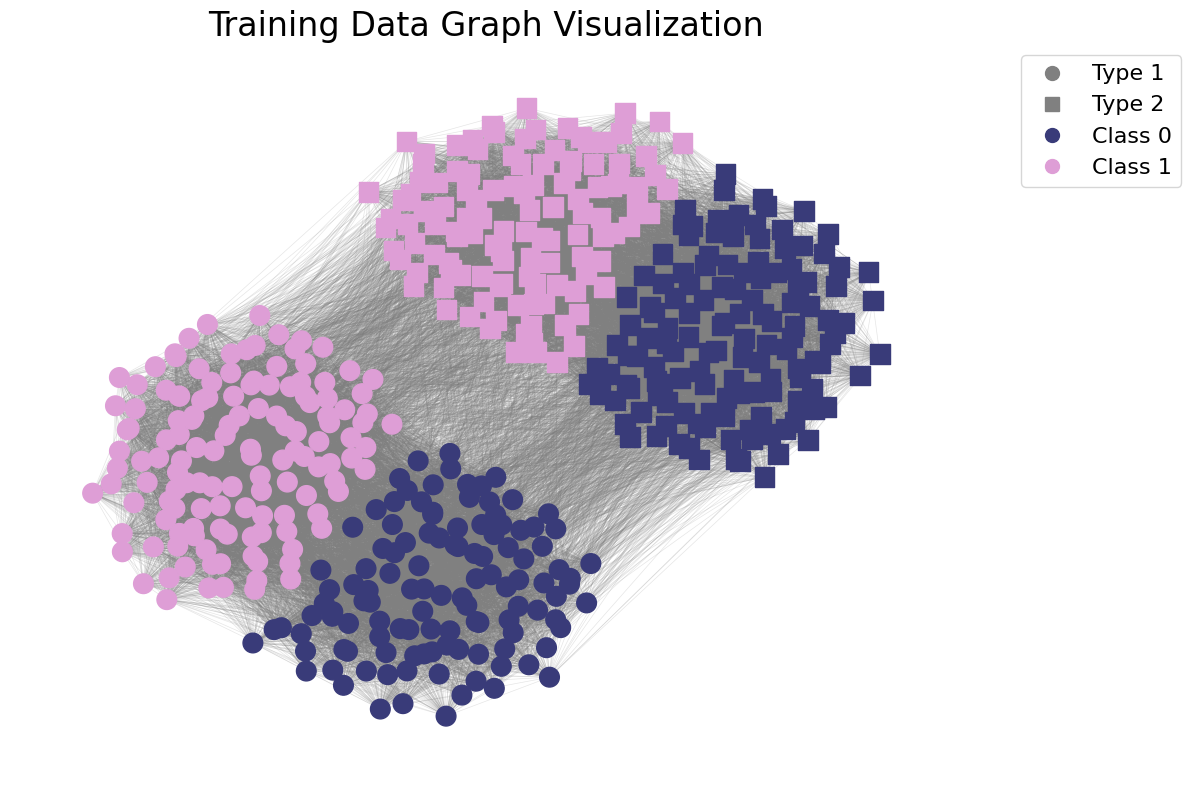

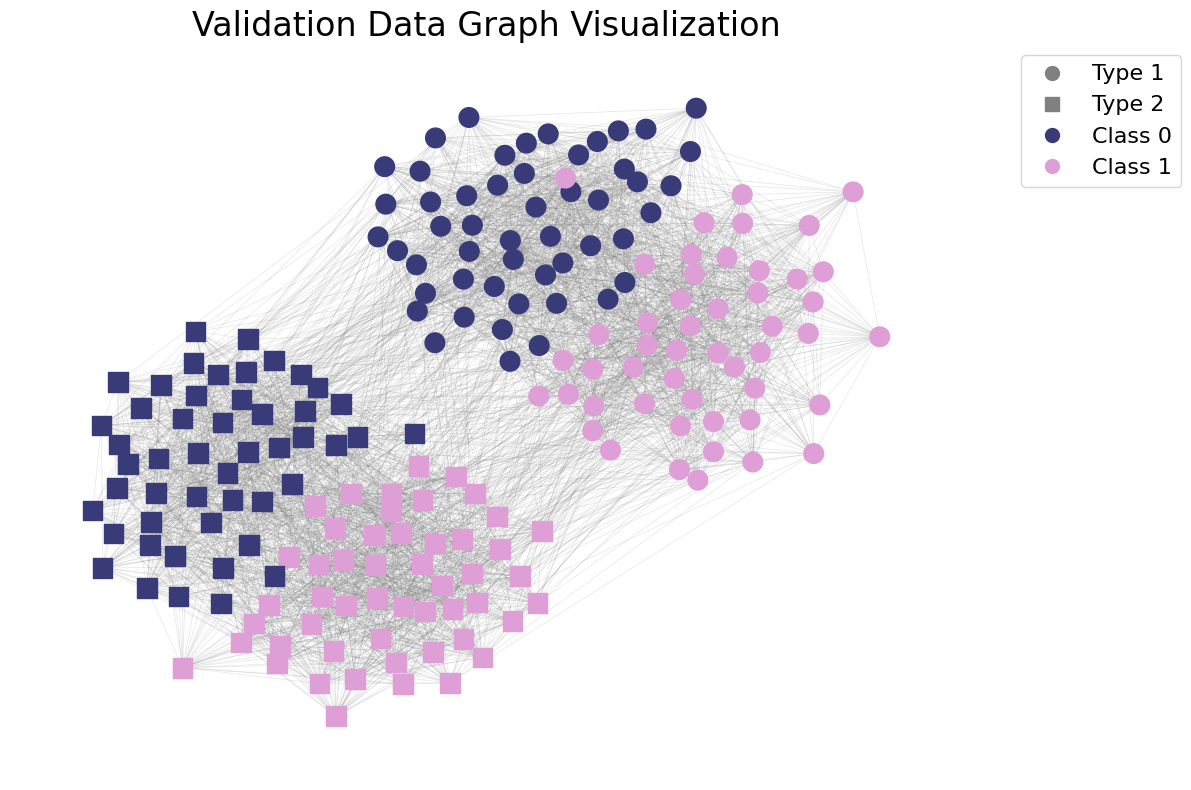

In [84]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

fig1 = plot_graph(A_train, mapping_train, y_train, title="Training Data Graph Visualization")
plt.show()
plt.close(fig1)

fig2 = plot_graph(A_val, mapping_val, y_val, title="Validation Data Graph Visualization")
plt.show()
plt.close(fig2)

# ####################################################
# END OF MODIFICATION
# ####################################################

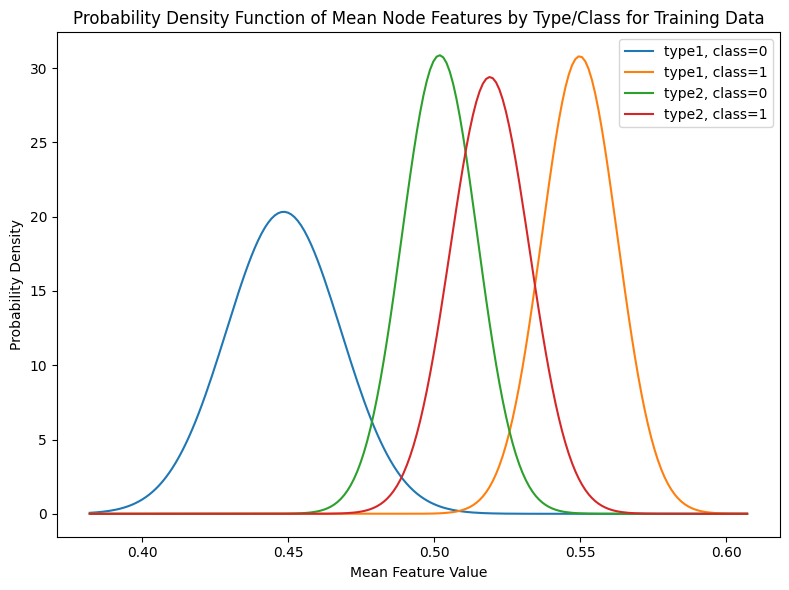

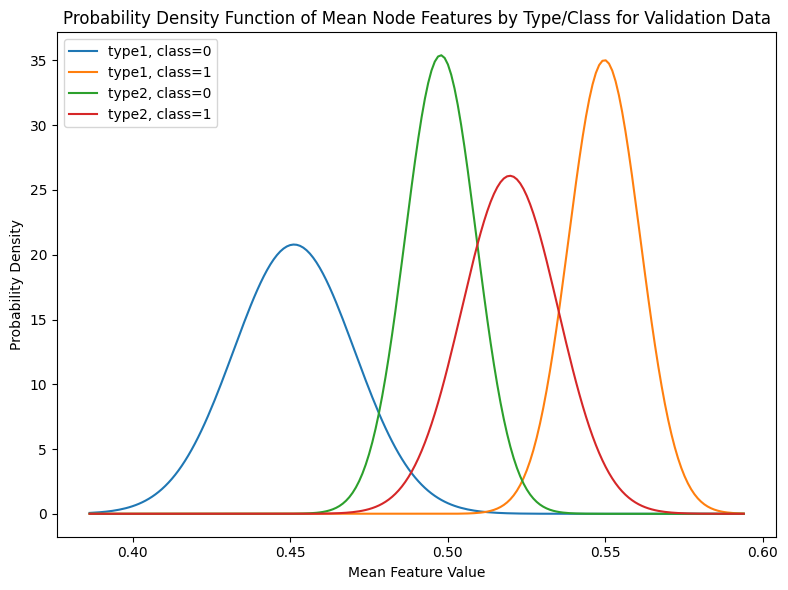

In [82]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

plot_node_feature_distributions(X1_train, X2_train, y_train, mapping_train, "Training")
plot_node_feature_distributions(X1_val, X2_val, y_val, mapping_val, suffix="Validation")
# ####################################################
# END OF MODIFICATION
# ####################################################

## Question 2.2 Naive Solution

Nothing to implement in Question 2.2 :)

In the naive solution, we handle the challenge of heterogeneous node feature dimensions by zero-padding all node feature vectors to match the maximum dimension. This ensures uniformity in the input dimensions for the Graph Convolutional Network (GCN).

### Zero Padding
Let the feature dimension of a node $i$ be $d_i$. To create uniform dimensions:

$$
\mathbf{x}_i^{\text{padded}} = \begin{bmatrix}
\mathbf{x}_i \\
\mathbf{0}
\end{bmatrix},
$$

where $ \mathbf{x}_i \in \mathbb{R}^{d_i} $ is the original feature vector, and the padding $ \mathbf{0} $ is of size $ d_{\text{max}} - d_i $. Here, $ d_{\text{max}} = \max\{d_i \mid i \in \text{nodes}\} $.


In [85]:
def pad_features(A, type1_features, type2_features, mapping):
    """
    Given:
      A : (N, N) adjacency
      type1_features : (num_type1, d1)
      type2_features : (num_type2, d2)
      mapping : a dict so that mapping[i] = {"node_type": "type1" or "type2",
                                             "feat_index": index in that type's feature array}

    Produces:
      X : torch.FloatTensor, shape (N, d_max)
        Where d_max = max(d1, d2).
        For each node i, we copy either type1_features or type2_features 
        into row i, zero-padding if needed.
      d_max : the dimension used for the padding.
    """
    device = A.device
    N = A.shape[0]

    # Determine the dimensions of type1 & type2
    d1 = type1_features.shape[1] if type1_features.ndim == 2 and type1_features.shape[0] > 0 else 0
    d2 = type2_features.shape[1] if type2_features.ndim == 2 and type2_features.shape[0] > 0 else 0

    d_max = max(d1, d2)

    # Create a (N, d_max) zero tensor
    X = torch.zeros((N, d_max), dtype=torch.float, device=device)

    # Fill each row
    for i in range(N):
        node_type = mapping[i]["node_type"]
        feat_index = mapping[i]["feat_index"]
        if node_type == "type1":
            # If we have any type1 features at all
            if d1 > 0:
                X[i, :d1] = type1_features[feat_index].to(device)
        else:
            # type2
            if d2 > 0:
                X[i, :d2] = type2_features[feat_index].to(device)

    return X, d_max


### Graph Convolutional Network (GCN)

We are going to use a 2-layer GCN for the **binary node classification** task on the heterogeneous graph. Below, you can see the mathematical representation to generate predictions from GCN.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
H_{k+1} = \sigma(\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H_k \Omega_k + \Beta_k)
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, $\Beta_k$ is the bias vector at layer $k$, and $\sigma $ denotes the activation function.


$\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$ is the normalized adjacency matrix with self-loops. Below, you need to implement this normalization function.

In [87]:
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


In [88]:
A_train_self_loops = A_train + torch.eye(A_train.size(0))
A_val_self_loops = A_val + torch.eye(A_val.size(0))

A_train_normalized = symmetric_normalize(A_train_self_loops)
A_val_normalized = symmetric_normalize(A_val_self_loops)

In the following cell, we define a simple 2-layer GCN model to use with our padded node features.


In [89]:
class GCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(GCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class GraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(GraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = GCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = GCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, **kwargs):
        # Pass through GCN layers
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)  # Output shape: (num_nodes, 1)

        output = torch.sigmoid(H2)  # Sigmoid activation per node
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, H1, H2
        else:
            return output

Please do not modify the following `train_model` and `evaluate_model` functions.

In [90]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(
    model,
    y_train,
    val_model_inputs,
    y_val,
    num_epochs=100,
    lr=0.01,
    validate_every=10,
    patience=10,
    **train_model_inputs
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the 
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    y_train : torch.Tensor
        Training labels (shape: (N,)).
    val_model_inputs : dict
        Dictionary of keyword arguments for the model's forward pass 
        for the validation set.
    y_val : torch.Tensor
        Validation labels (shape: (N_val,)).
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    validate_every : int
        Validate (and possibly checkpoint) every 'validate_every' epochs.
    **train_model_inputs :
        Keyword arguments for the model's forward pass for the training set.

    Returns:
    --------
    best_loss_history : list
        The training loss history across epochs.
    best_model_state_dict : dict
        The state dictionary of the model achieving the best validation accuracy.
    """

    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=patience)
    loss_history = []

    best_val_f1 = 0.0
    best_model_state_dict = None

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()


        # Forward pass on training data
        out = model(**train_model_inputs)  # shape: (N, 1)
        out = out.squeeze(-1)  # shape: (N,)
        y_float = y_train.float()  # for BCE

        # Compute training loss
        loss = binary_cross_entropy(out, y_float)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Record training loss
        loss_value = loss.item()
        loss_history.append(loss_value)

        # Validation step
        if (epoch + 1) % validate_every == 0 or (epoch + 1) == num_epochs:
            val_prec, val_rec, val_f1, _ = evaluate_model(model, y_val, **val_model_inputs)
            scheduler.step(val_f1)
            
            lr = get_lr(optimizer)

            print(
                f"Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {loss_value:.4f} - "
                f"Val Precision: {val_prec:.4f} - "
                f"Val Recall: {val_rec:.4f} - "
                f"Val F1: {val_f1:.4f} - "
                f"LR: {lr}"
            )
    
            # Check if this is the best f1 score so far
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model_state_dict = copy.deepcopy(model.state_dict())


            if lr < 1e-5:
                break

    
    # If we have a best model, load it
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return loss_history, best_model_state_dict


@torch.no_grad()
def evaluate_model(model, y, **kwargs):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """
    model.eval()
    out = model(**kwargs)  # shape: (N, 1)
    out = out.squeeze(-1)  # shape: (N,)
    preds = (out >= 0.5).long()

    y_true = y.cpu().numpy()
    y_pred = preds.cpu().numpy()

    return precision_recall_fscore_support(y_true, y_pred, average="micro")


Helper function to plot the history of loss during the training.

In [91]:
def plot_loss(loss_history, title):
    plt.figure()
    plt.plot(loss_history, label="loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [92]:

def plot_results(val_precs, val_recs, val_f1s, title_prefix='', figsize=(15,5)):
    """
    Plots three bar charts comparing precision, recall, and F1 scores 
    for multiple models on a single figure, each sorted by its own metric.
    The best model is always on the right for each plot.
    
    Args:
        val_precs (dict): Dictionary of model -> precision score
        val_recs (dict): Dictionary of model -> recall score
        val_f1s (dict): Dictionary of model -> F1 score
        title_prefix (str): Optional prefix for subplot titles
        figsize (tuple): Size of the overall figure
    """
    
    # Prepare the figure
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    # --- Sort and plot Precision ---
    # Sort by precision (ascending), so best is on the right
    sorted_precs = sorted(val_precs.items(), key=lambda x: x[1])
    prec_models = [x[0] for x in sorted_precs]  # model names
    prec_scores = [x[1] for x in sorted_precs]  # scores
    min_prec = min(prec_scores)
    
    axes[0].bar(prec_models, prec_scores, color='skyblue')
    # Start the y-axis a bit lower than the min value
    axes[0].set_ylim([
        min_prec - 0.05*(1 if min_prec == 0 else min_prec), 
        max(1.0, max(prec_scores))  # in case some scores > 1.0
    ])
    axes[0].set_title(f'{title_prefix}Precision', fontsize=12)
    axes[0].set_ylabel('Score')
    axes[0].set_xticks(range(len(prec_models)))
    axes[0].set_xticklabels(prec_models, rotation=45, ha='right')
    
    # --- Sort and plot Recall ---
    sorted_recs = sorted(val_recs.items(), key=lambda x: x[1])
    rec_models = [x[0] for x in sorted_recs]
    rec_scores = [x[1] for x in sorted_recs]
    min_recs = min(rec_scores)
    
    axes[1].bar(rec_models, rec_scores, color='salmon')
    axes[1].set_ylim([
        min_recs - 0.05*(1 if min_recs == 0 else min_recs),
        max(1.0, max(rec_scores))
    ])
    axes[1].set_title(f'{title_prefix}Recall', fontsize=12)
    axes[1].set_xticks(range(len(rec_models)))
    axes[1].set_xticklabels(rec_models, rotation=45, ha='right')
    
    # --- Sort and plot F1 ---
    sorted_f1s = sorted(val_f1s.items(), key=lambda x: x[1])
    f1_models = [x[0] for x in sorted_f1s]
    f1_scores = [x[1] for x in sorted_f1s]
    min_f1 = min(f1_scores)
    
    axes[2].bar(f1_models, f1_scores, color='limegreen')
    axes[2].set_ylim([
        min_f1 - 0.05*(1 if min_f1 == 0 else min_f1),
        max(1.0, max(f1_scores))
    ])
    axes[2].set_title(f'{title_prefix}F1', fontsize=12)
    axes[2].set_xticks(range(len(f1_models)))
    axes[2].set_xticklabels(f1_models, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


In [93]:
val_precs, val_recs, val_f1s = {}, {}, {}

Running the naive approach

Train adjacency: torch.Size([500, 500])
Train features after padding: torch.Size([500, 30]) with d_max = 30
Val adjacency: torch.Size([200, 200])
Val features after padding: torch.Size([200, 30]) with d_max = 30
Epoch 10/10000 - Train Loss: 0.6906 - Val Precision: 0.5000 - Val Recall: 0.5000 - Val F1: 0.5000 - LR: 0.01
Epoch 20/10000 - Train Loss: 0.6883 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 30/10000 - Train Loss: 0.6868 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 40/10000 - Train Loss: 0.6866 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 50/10000 - Train Loss: 0.6863 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 60/10000 - Train Loss: 0.6860 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 70/10000 - Train Loss: 0.6856 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 80/10000 - Train Lo

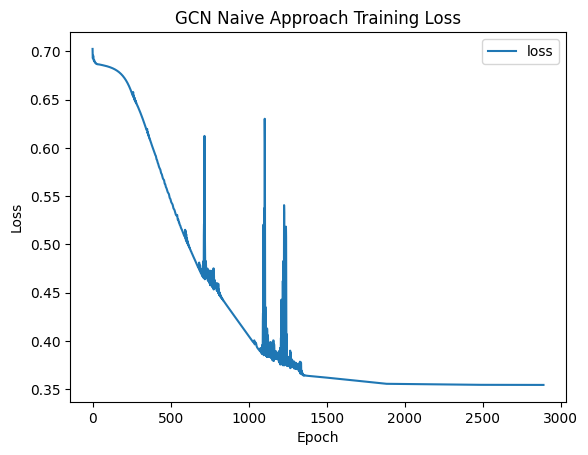

In [202]:
set_seed(SEED)

# Naively pad
X_train, d_max_train = pad_features(A_train, X1_train, X2_train, mapping_train)
X_val,   d_max_val   = pad_features(A_val,   X1_val,   X2_val,   mapping_val)

print("Train adjacency:", A_train.shape)
print("Train features after padding:", X_train.shape, "with d_max =", d_max_train)
print("Val adjacency:", A_val.shape)
print("Val features after padding:", X_val.shape, "with d_max =", d_max_val)

# Convert labels to float if using BCE with sigmoid
y_train = y_train.float()  # shape (N,)
y_val   = y_val.float()

# Build the GCN model
input_dim = X_train.shape[1]  # the padded dimension
hidden_dim = 2
naive_gnn_model = GraphNeuralNetwork(input_dim, hidden_dim)

# Train
loss_history, _ = train_model(naive_gnn_model, y_train, val_model_inputs={"A":A_val_normalized.clone(), "X":X_val.clone()}, y_val=y_val.clone(), A=A_train_normalized, X=X_train, num_epochs=10000, lr=0.01, patience=50)

# Test on validation data
val_prec, val_rec, val_f1, _ = evaluate_model(naive_gnn_model, y_val, A=A_val_normalized, X=X_val)
print(f"[VAL] Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")

val_precs["Naive GCN"] = val_prec
val_recs["Naive GCN"] = val_rec
val_f1s["Naive GCN"] = val_f1

# Plot loss
plot_loss(loss_history, title="GCN Naive Approach Training Loss")


## Question 2.3 Node-Type Aware GCN

In this task, **design and implement** a node-type aware 2-layer GCN model that explicitly accounts for two distinct node types and performs binary node classification. Your design should adhere to the following requirements:

- Consider two types of nodes without using padding.
- Limit your model to **two layers**, as in the naive solution.
- You may either use the provided `GCNLayer` and `GraphNeuralNetwork` classes or implement your own classes. However, the final model architecture must be implemented within the `HeteroGCN` class.
- While you are allowed to introduce additional learnable parameters, your approach must **explicitly** account for different node types rather than merely increasing the number of learnable parameters.
- Determine the optimal hyperparameters for your model, such as hidden dimensions, learning rate, scheduler patience, etc. These hyperparameters do not need to match those of the naive model, as each design has its own optimal configuration.
- Your model must achieve superior **validation F1 score** compared to the naive approach.
- You may use different versions of adjacency matrices in your implementation:
  - Unmodified adjacency matrices, i.e., `A_train`.
  - Self-looped adjacency matrices, i.e., `A_train_self_loops`.
  - Normalized adjacency matrices, i.e., `A_train_normalized`.

Please see the Coursework Description PDF Question 2.3 for more details

In [323]:
def split_adjacency_matrix(A, num_type1_nodes):
    A11 = A[:num_type1_nodes, :num_type1_nodes] # type1-type1
    A12 = A[:num_type1_nodes, num_type1_nodes:] # type1-type2
    A21 = A[num_type1_nodes:, :num_type1_nodes] # type2-type1
    A22 = A[num_type1_nodes:, num_type1_nodes:] # type2-type2
    return A11, A12, A21, A22

class HeteroGCNLayer(nn.Module):
    def __init__(self, input_dim_t1, input_dim_t2, output_dim):
        super(HeteroGCNLayer, self).__init__()
        self.gcn1 = nn.Linear(input_dim_t1, output_dim)
        self.gcn2 = nn.Linear(input_dim_t2, output_dim)

    def forward(self, X1, X2, A11, A12, A21, A22):
        x1_mults = self.gcn1(X1)
        x2_mults = self.gcn2(X2)

        # aggregation
        output1 = A11 @ x1_mults + A12 @ x2_mults
        output2 = A21 @ x1_mults + A22 @ x2_mults

        return output1, output2

class HeteroGCN(nn.Module):
    def __init__(self, input_dim_t1, input_dim_t2, hidden_dim, output_dim=1):
        super(HeteroGCN, self).__init__()
        self.layer1 = HeteroGCNLayer(input_dim_t1, input_dim_t2, hidden_dim)
        self.layer2 = HeteroGCNLayer(hidden_dim, hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, X1, X2, A11, A12, A21, A22):
        # outputs after going through first layer
        out_1, out_2 = self.layer1(X1, X2, A11, A12, A21, A22)
        h1, h2 = self.relu(out_1), self.relu(out_2) # apply non-linearity

        # outputs after going through second layer
        z1, z2 = self.layer2(h1, h2, A11, A12, A21, A22)
        final_out = torch.cat([z1, z2], dim=0)

        # transforming to single output prediction
        label_prob = torch.sigmoid(final_out)
        return label_prob

Epoch 10/20000 - Train Loss: 0.6864 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 20/20000 - Train Loss: 0.6859 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 30/20000 - Train Loss: 0.6852 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 40/20000 - Train Loss: 0.6841 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 50/20000 - Train Loss: 0.6829 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 60/20000 - Train Loss: 0.6812 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 70/20000 - Train Loss: 0.6792 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 80/20000 - Train Loss: 0.6765 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 90/20000 - Train Loss: 0.6728 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.015
Epoch 100/

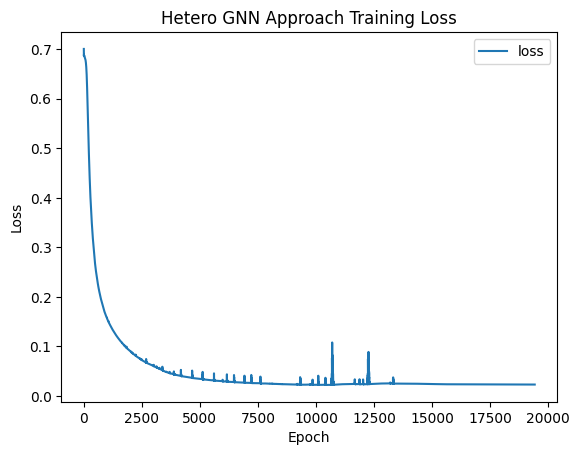

In [336]:
set_seed(SEED)

# Convert labels to float if using BCE with sigmoid
y_train = y_train.float()  # shape (N,)
y_val   = y_val.float()

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
# Build the HeteroGCN model
input_dim1 = X1_train.shape[1]
input_dim2 = X2_train.shape[1]
hidden_dim = 3
hetero_gcn = HeteroGCN(input_dim1, input_dim2, hidden_dim)

# split adjacency matrix to account for edges of different types
A11_train, A12_train, A21_train, A22_train = split_adjacency_matrix(A_train_normalized, X1_train.shape[0])
A11_val, A12_val, A21_val, A22_val = split_adjacency_matrix(A_val_normalized, X1_val.shape[0])

train_inputs = {"X1": X1_train, "X2": X2_train, "A11": A11_train, "A12": A12_train, "A21": A21_train, "A22": A22_train}

val_inputs = {"X1": X1_val, "X2": X2_val, "A11": A11_val, "A12": A12_val, "A21": A21_val, "A22": A22_val}

# Train
num_epochs = 20000
lr = 0.015
loss_history, _ = train_model(hetero_gcn, y_train, val_model_inputs=val_inputs, y_val=y_val, num_epochs=num_epochs, lr=lr, patience=200, **train_inputs)


# ####################################################
# END OF MODIFICATION
# ####################################################

# Test on validation data
val_prec, val_rec, val_f1, _ = evaluate_model(hetero_gcn, y_val, **val_inputs)
print(f"[VAL] Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")

val_precs["Hetero GCN"] = val_prec
val_recs["Hetero GCN"] = val_rec
val_f1s["Hetero GCN"] = val_f1

# Plot loss
plot_loss(loss_history, title="Hetero GNN Approach Training Loss")


## Question 2.4 Exploring Attention
In this question, you will explore the attention-based aggregation mechanism in GNNs. Attention-based aggregation is explained in [Lecture 3.5](https://www.youtube.com/watch?v=zRmzVkidkqA&list=PLug43ldmRSo14Y_vt7S6vanPGh-JpHR7T&index=14).

- Implement an attention-based aggregation mechanism for binary node classification using GCNs.
- Limit your model to **two layers**, as in Question 2.2 and Question 2.3
- Base your implementation on the naive padding approach introduced in Question 2.2
- **Do not** implement a node-type aware special design as in Question 2.3
- Your implementation must achieve a better **validation F1 score** compared to the naive GCN in Question 2.2
- Determine the optimal hyperparameters for your model, such as hidden dimensions, learning rate, scheduler patience, etc. These hyperparameters do not need to match those of the previous models, as each design has its own optimal configuration. Explain your hyperparameter tuning process **in detail** in your report.



In [24]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

class GraphAttentionNetwork(nn.Module):
    pass

# ####################################################
# END OF MODIFICATION
# ####################################################

In [ ]:
set_seed(SEED)

# Naively pad
X_train, d_max_train = pad_features(A_train, X1_train, X2_train, mapping_train)
X_val,   d_max_val   = pad_features(A_val,   X1_val,   X2_val,   mapping_val)

print("Train adjacency:", A_train.shape)
print("Train features after padding:", X_train.shape, "with d_max =", d_max_train)
print("Val adjacency:", A_val.shape)
print("Val features after padding:", X_val.shape, "with d_max =", d_max_val)

# Convert labels to float if using BCE with sigmoid
y_train = y_train.float()  # shape (N,)
y_val   = y_val.float()


# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

# Build the model
attn_gnn = GraphAttentionNetwork(...)

# Train
loss_history, _ = train_model(attn_gnn, y_train, val_model_inputs={...}, y_val=y_val, ...)

# ####################################################
# END OF MODIFICATION
# ####################################################

# Test on validation data
val_prec, val_rec, val_f1, _ = evaluate_model(attn_gnn, y_val, ...)
print(f"[VAL] Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")

val_precs["Naive GAT"] = val_prec
val_recs["Naive GAT"] = val_rec
val_f1s["Naive GAT"] = val_f1

# Plot loss
plot_loss(loss_history, title="GAT Naive Approach Training Loss")

## Question 2.5 Discussion

In your report, include the bar plot comparing the **precision, recall, and F1 scores** of the three models, generated using the following function call. Explain your results in your report.

In [ ]:
plot_results(val_precs, val_recs, val_f1s)